In [4]:
from surprise import Dataset, Reader
from surprise import dump
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from surprise import accuracy, Dataset, SVD, KNNBasic, KNNWithMeans, KNNWithZScore,Prediction,SlopeOne
from surprise.model_selection import GridSearchCV
from surprise import Prediction
from collections import defaultdict
from sklearn.linear_model import LinearRegression

In [2]:
#Leggi Dati e dividi in trainset e testset
# DATABASE 1M contenente i rating
data = Dataset.load_builtin("ml-1m")

raw_ratings = data.raw_ratings

# shuffle ratings if you want
random.shuffle(raw_ratings)

# A = 80% of the data, B = 20% of the data
threshold = int(0.8 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

data.raw_ratings = A_raw_ratings  # data is now the set A

# costruisci il trainset su A
trainset = data.build_full_trainset()

# costruisci il test set su B
testset = data.construct_testset(B_raw_ratings)  # testset is now the set B

In [8]:
#leggo i dataset contenenti i film con relativi id,nomi e generi
movies_df = pd.read_csv('dataset/ml-1m/movies.dat',
                        delimiter='::', engine= 'python', header=None,
                        names=['movie_id','movie_name', 'genre'], encoding='latin-1')
movies_df.head()

#creo un dizionario che collega gli id dei film ai relativi titoli

idToName = movies_df.set_index('movie_id').transpose().to_dict(orient='dict')

In [13]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [14]:
#allenamento modello SVD con iperparametri trovati
algo_svd = SVD(n_epochs=30,reg_all=0.05, verbose= False)
algo_svd.fit(trainset)

In [17]:
dump.dump(file_name='modelli_Allenati/SVD',algo=algo_svd)

In [18]:
#allenamento modello knn base user-based con iperparametri trovati
algo_knnBase_u = KNNBasic(k=49,sim_options= {'name': 'pearson', 'user_based': True}, verbose= False)
algo_knnBase_u.fit(trainset)

In [19]:
dump.dump(file_name='modelli_Allenati/KnnBase_u',algo=algo_knnBase_u)

In [20]:
#allenamento modello knn base user-based con iperparametri trovati
algo_knnBase_i = KNNBasic(k=49,sim_options= {'name': 'msd', 'user_based': False}, verbose= False)
algo_knnBase_i.fit(trainset)
dump.dump(file_name='modelli_Allenati/KnnBase_i',algo=algo_knnBase_i)

In [21]:
#allenamento modello knn base ibrido con iperparametri trovati

#costruisco un test-set sull training set
biasdtestset=trainset.build_testset()
#predicco i rating sul set con i modelli item-based e user-based 
predictions1 = algo_knnBase_u.test(biasdtestset)
predictions2 = algo_knnBase_i.test(biasdtestset)

#prendo solo i rating predetti e quelli reali per costruire il training set dell'algoritmo ibrido
X=[]
y=[]
for i in range(len(predictions1)):
    X.append([predictions1[i][3],predictions2[i][3]])
    y.append(predictions1[i][2])
#uso regressione lineare per predirre i rating reali sulla base delle predizioni user-based e item-based
algo_KnnBase_ibrido = LinearRegression().fit(X, y)
dump.dump(file_name='modelli_Allenati/algo_KnnBase_ibrido',algo=algo_KnnBase_ibrido)

In [26]:
#funzione che riporta le predizioni del modello ibrido nello stesso formato degli altri
def predictIbrido(algo_ibrido,algo_user,algo_item,set):
     """returns the predictions for thy hybrid model based on those
        made by the user-based and item-based models.

    Args:
        algo_KnnBase_ibrido(string): the trained hybrid model to use.
        algo_user: the trained model for user-based predictions to use.
        algo_item: the trained model for user-based predictions to use.
        set: the set of ratings to predict

    Returns:
        list of Prediction objects
    """
     predictions1 = algo_user.test(set)
     predictions2 = algo_item.test(set)
     X=[]
     y=[]
     for i in range(len(predictions1)):
        X.append([predictions1[i][3],predictions2[i][3]])
        y.append(predictions1[i][2])
    
     algo_ibrido.score(X, y)
     predictionsIbride=algo_ibrido.predict(X)
     predFinali=[]
     for i in range(len(predictions1)):
        predFinali.append(Prediction(predictions1[i].uid, predictions1[i].iid, predictions1[i].r_ui, predictionsIbride[i], predictions1[i].details))
     return predFinali

In [27]:
#allenamento modello knn con media user-based con iperparametri trovati
algo_knnMeans_u = KNNWithMeans(k=49,sim_options= {'name': 'msd', 'user_based': True}, verbose= False)
algo_knnMeans_u.fit(trainset)
dump.dump(file_name='modelli_Allenati/algo_knnMeans_u',algo=algo_knnMeans_u)

In [28]:
#allenamento modello knn base user-based con iperparametri trovati
algo_knnMeans_i = KNNWithMeans(k=49,sim_options= {'name': 'msd', 'user_based': False}, verbose= False)
algo_knnMeans_i.fit(trainset)
dump.dump(file_name='modelli_Allenati/algo_knnMeans_i',algo=algo_knnMeans_i)

In [29]:
#allenamento modello knn base ibrido con iperparametri trovati

#costruisco un test-set sull training set
biasdtestset=trainset.build_testset()
#predicco i rating sul set con i modelli item-based e user-based 
predictions1_m = algo_knnMeans_u.test(biasdtestset)
predictions2_m = algo_knnMeans_i.test(biasdtestset)

#prendo solo i rating predetti e quelli reali per costruire il training set dell'algoritmo ibrido
X=[]
y=[]
for i in range(len(predictions1_m)):
    X.append([predictions1_m[i][3],predictions2_m[i][3]])
    y.append(predictions1_m[i][2])
#uso regressione lineare per predirre i rating reali sulla base delle predizioni user-based e item-based
algo_KnnMeans_ibrido = LinearRegression().fit(X, y)
dump.dump(file_name='modelli_Allenati/algo_KnnMeans_ibrido',algo=algo_KnnMeans_ibrido)

In [30]:
#allenamento modello SlopeOne
slopeOne = SlopeOne()
slopeOne.fit(trainset)
dump.dump(file_name='modelli_Allenati/slopeOne',algo=slopeOne)

In [33]:
#risultati ottenuti svd

# training errors
biasSet=trainset.build_testset()
predictions_svd_train = algo_svd.test(biasSet)
print("Biased accuracy on trainset svd,", end="   ")
accuracy.rmse(predictions_svd_train)
accuracy.mse(predictions_svd_train)
accuracy.mae(predictions_svd_train)

# test errors
predictions_svd_test=algo_svd.test(testset)
print("Unbiased accuracy on testset,", end=" ")
accuracy.rmse(predictions_svd_test)
accuracy.mse(predictions_svd_test)
accuracy.mae(predictions_svd_test)

precisions, recalls = precision_recall_at_k(predictions_svd_test, k=10, threshold=4)
print("precision: ")
print(sum(prec for prec in precisions.values()) / len(precisions))
print("recall: ")
print(sum(rec for rec in recalls.values()) / len(recalls))

Biased accuracy on trainset svd,   RMSE: 0.7348
MSE: 0.5399
MAE:  0.5833
Unbiased accuracy on testset, RMSE: 0.8572
MSE: 0.7347
MAE:  0.6761
precision: 
0.7514576789726016
recall: 
0.3431329161442998


In [34]:
#risultati ottenuti Knn user-based

# training errors
predictions_KnnB_u_train = algo_knnBase_u.test(biasSet)
print("Biased accuracy on trainset svd,", end="   ")
accuracy.rmse(predictions_KnnB_u_train)
accuracy.mse(predictions_KnnB_u_train)
accuracy.mae(predictions_KnnB_u_train)

# test errors
predictions_KnnB_u_test=algo_knnBase_u.test(testset)
print("Unbiased accuracy on testset,", end=" ")
accuracy.rmse(predictions_KnnB_u_test)
accuracy.mse(predictions_KnnB_u_test)
accuracy.mae(predictions_KnnB_u_test)

precisions, recalls = precision_recall_at_k(predictions_KnnB_u_test, k=10, threshold=4)
print("precision: ")
print(sum(prec for prec in precisions.values()) / len(precisions))
print("recall: ")
print(sum(rec for rec in recalls.values()) / len(recalls))

Biased accuracy on trainset svd,   RMSE: 0.6789
MSE: 0.4608
MAE:  0.5128
Unbiased accuracy on testset, RMSE: 0.9228
MSE: 0.8515
MAE:  0.7277
precision: 
0.7851060919340725
recall: 
0.3920950352170502


In [35]:
#risultati ottenuti Knn item-based

# training errors
predictions_KnnB_i_train = algo_knnBase_i.test(biasSet)
print("Biased accuracy on trainset svd,", end="   ")
accuracy.rmse(predictions_KnnB_i_train)
accuracy.mse(predictions_KnnB_i_train)
accuracy.mae(predictions_KnnB_i_train)

# test errors
predictions_KnnB_i_test=algo_knnBase_i.test(testset)
print("Unbiased accuracy on testset,", end=" ")
accuracy.rmse(predictions_KnnB_i_test)
accuracy.mse(predictions_KnnB_i_test)
accuracy.mae(predictions_KnnB_i_test)

precisions, recalls = precision_recall_at_k(predictions_KnnB_i_test, k=10, threshold=4)
print("precision: ")
print(sum(prec for prec in precisions.values()) / len(precisions))
print("recall: ")
print(sum(rec for rec in recalls.values()) / len(recalls))

Biased accuracy on trainset svd,   RMSE: 0.7599
MSE: 0.5774
MAE:  0.5898
Unbiased accuracy on testset, RMSE: 0.9159
MSE: 0.8388
MAE:  0.7213
precision: 
0.5221823686938085
recall: 
0.27933974192074956


In [36]:
#risultati ottenuti Knn media user-based

# training errors
predictions_KnnM_u_train = algo_knnMeans_u.test(biasSet)
print("Biased accuracy on trainset svd,", end="   ")
accuracy.rmse(predictions_KnnM_u_train)
accuracy.mse(predictions_KnnM_u_train)
accuracy.mae(predictions_KnnM_u_train)

# test errors
predictions_KnnM_u_test=algo_knnMeans_u.test(testset)
print("Unbiased accuracy on testset,", end=" ")
accuracy.rmse(predictions_KnnM_u_test)
accuracy.mse(predictions_KnnM_u_test)
accuracy.mae(predictions_KnnM_u_test)

precisions, recalls = precision_recall_at_k(predictions_KnnM_u_test, k=10, threshold=4)
print("precision: ")
print(sum(prec for prec in precisions.values()) / len(precisions))
print("recall: ")
print(sum(rec for rec in recalls.values()) / len(recalls))

Biased accuracy on trainset svd,   RMSE: 0.7132
MSE: 0.5087
MAE:  0.5540
Unbiased accuracy on testset, RMSE: 0.9263
MSE: 0.8579
MAE:  0.7367
precision: 
0.6255770212183909
recall: 
0.3217260706326117


In [37]:
#risultati ottenuti Knn con media item-based

# training errors
predictions_KnnM_i_train = algo_knnMeans_i.test(biasSet)
print("Biased accuracy on trainset svd,", end="   ")
accuracy.rmse(predictions_KnnM_i_train)
accuracy.mse(predictions_KnnM_i_train)
accuracy.mae(predictions_KnnM_i_train)

# test errors
predictions_KnnM_i_test=algo_knnMeans_i.test(testset)
print("Unbiased accuracy on testset,", end=" ")
accuracy.rmse(predictions_KnnM_i_test)
accuracy.mse(predictions_KnnM_i_test)
accuracy.mae(predictions_KnnM_i_test)

precisions, recalls = precision_recall_at_k(predictions_KnnM_i_test, k=10, threshold=4)
print("precision: ")
print(sum(prec for prec in precisions.values()) / len(precisions))
print("recall: ")
print(sum(rec for rec in recalls.values()) / len(recalls))

Biased accuracy on trainset svd,   RMSE: 0.7501
MSE: 0.5626
MAE:  0.5860
Unbiased accuracy on testset, RMSE: 0.8851
MSE: 0.7835
MAE:  0.6951
precision: 
0.7243822703095227
recall: 
0.3476985887485839


In [38]:
#risultati ottenuti SlopeOne

# training errors
predictions_slopeOne_train = slopeOne.test(biasSet)
print("Biased accuracy on trainset svd,", end="   ")
accuracy.rmse(predictions_slopeOne_train)
accuracy.mse(predictions_slopeOne_train)
accuracy.mae(predictions_slopeOne_train)

# test errors
predictions_slopeOne_test=slopeOne.test(testset)
print("Unbiased accuracy on testset,", end=" ")
accuracy.rmse(predictions_slopeOne_test)
accuracy.mse(predictions_slopeOne_test)
accuracy.mae(predictions_slopeOne_test)

precisions, recalls = precision_recall_at_k(predictions_slopeOne_test, k=10, threshold=4)
print("precision: ")
print(sum(prec for prec in precisions.values()) / len(precisions))
print("recall: ")
print(sum(rec for rec in recalls.values()) / len(recalls))

Biased accuracy on trainset svd,   RMSE: 0.8695
MSE: 0.7560
MAE:  0.6852
Unbiased accuracy on testset, RMSE: 0.9061
MSE: 0.8210
MAE:  0.7149
precision: 
0.7173578557486462
recall: 
0.3386317120869436


In [39]:
#risultati ottenuti Knn ibrido

prediction_ibridoB_train=predictIbrido(algo_KnnBase_ibrido,algo_knnBase_u,algo_knnBase_i,biasSet)
print("Biased accuracy on trainset,", end="   ")
accuracy.rmse(prediction_ibridoB_train)
accuracy.mse(prediction_ibridoB_train)
accuracy.mae(prediction_ibridoB_train)

prediction_ibridoB_test=predictIbrido(algo_KnnBase_ibrido,algo_knnBase_u,algo_knnBase_i,testset)
print("Biased accuracy on trainset,", end="   ")
accuracy.rmse(prediction_ibridoB_test)
accuracy.mse(prediction_ibridoB_test)
accuracy.mae(prediction_ibridoB_test)

precisions, recalls = precision_recall_at_k(prediction_ibridoB_test, k=10, threshold=4)
print("precision: ")
print(sum(prec for prec in precisions.values()) / len(precisions))
print("recall: ")
print(sum(rec for rec in recalls.values()) / len(recalls))

Biased accuracy on trainset,   RMSE: 0.6101
MSE: 0.3722
MAE:  0.4640
Biased accuracy on trainset,   RMSE: 0.8975
MSE: 0.8054
MAE:  0.7032
precision: 
0.7672248791241224
recall: 
0.37819100013350215


In [40]:
#risultati ottenuti Knn con media ibrido 

prediction_ibridoM_train=predictIbrido(algo_KnnMeans_ibrido,algo_knnMeans_u,algo_knnMeans_i,biasSet)
print("Biased accuracy on trainset,", end="   ")
accuracy.rmse(prediction_ibridoM_train)
accuracy.mse(prediction_ibridoM_train)
accuracy.mae(prediction_ibridoM_train)

prediction_ibridoM_test=predictIbrido(algo_KnnMeans_ibrido,algo_knnMeans_u,algo_knnMeans_i,testset)
print("Biased accuracy on trainset,", end="   ")
accuracy.rmse(prediction_ibridoM_test)
accuracy.mse(prediction_ibridoM_test)
accuracy.mae(prediction_ibridoM_test)

precisions, recalls = precision_recall_at_k(prediction_ibridoM_test, k=10, threshold=4)
print("precision: ")
print(sum(prec for prec in precisions.values()) / len(precisions))
print("recall: ")
print(sum(rec for rec in recalls.values()) / len(recalls))

Biased accuracy on trainset,   RMSE: 0.6898
MSE: 0.4759
MAE:  0.5353
Biased accuracy on trainset,   RMSE: 0.9093
MSE: 0.8268
MAE:  0.7129
precision: 
0.7057435774000307
recall: 
0.3766595927917136


In [47]:
d = {'algo': ["SVD","Knn user","Knn item","KnnM user","KnnM item", "SlopeOne","Knn ibrido","KnnM ibrido"], 
'train_error_RMSE': [0.7348, 0.6789,0.7599,0.7132,0.7501, 0.8695,0.6101,0.6898], 
'train_error_MSE': [0.5399, 0.4608,0.5774,0.5087,0.5626, 0.7560,0.3722,0.4759],
'train_error_MAE': [0.5833,0.5128, 0.5898,0.5540,0.5860,  0.6852,0.4640,0.5353],
'train_time': [10.724332809448242, 30.95148015022278,10.40069317817688,30.759082078933716,10.558875560760498,9.275396585464478,417.14910316467285,418.52566623687744],
'test_error_RMSE': [0.8572,0.9228, 0.9159,0.9263,0.8851,  0.9061,0.8975,0.9093], 
'test_error_MSE': [0.7347,0.8515,0.8388,0.8579,0.7835, 0.8210,0.8054,0.8268], 
'test_error_MAE': [0.6761,0.7277,0.7213,0.7367,0.6951,0.7149, 0.7032,0.7129],
'precision': [0.7514576789726016,0.7851060919340725,0.5221823686938085,0.6255770212183909,0.7243822703095227, 0.7173578557486462,0.7672248791241224,0.7057435774000307], 
'recall': [0.7514576789726016,0.3920950352170502,0.27933974192074956,0.3217260706326117,0.3476985887485839, 0.3386317120869436,0.37819100013350215,0.3766595927917136] }
df = pd.DataFrame(data=d)

In [48]:
df

,algo,train_error_RMSE,train_error_MSE,train_error_MAE,train_time,test_error_RMSE,test_error_MSE,test_error_MAE,precision,recall
0,SVD,0.7348,0.5399,0.5833,10.724333,0.8572,0.7347,0.6761,0.751458,0.751458
1,Knn user,0.6789,0.4608,0.5128,30.951480,0.9228,0.8515,0.7277,0.785106,0.392095
2,Knn item,0.7599,0.5774,0.5898,10.400693,0.9159,0.8388,0.7213,0.522182,0.279340
3,KnnM user,0.7132,0.5087,0.5540,30.759082,0.9263,0.8579,0.7367,0.625577,0.321726
4,KnnM item,0.7501,0.5626,0.5860,10.558876,0.8851,0.7835,0.6951,0.724382,0.347699
5,SlopeOne,0.8695,0.7560,0.6852,9.275397,0.9061,0.8210,0.7149,0.717358,0.338632
6,Knn ibrido,0.6101,0.3722,0.4640,417.149103,0.8975,0.8054,0.7032,0.767225,0.378191
7,KnnM ibrido,0.6898,0.4759,0.5353,418.525666,0.9093,0.8268,0.7129,0.705744,0.376660


C:\Users\Elia\AppData\Local\Temp\ipykernel_20980\1202154122.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


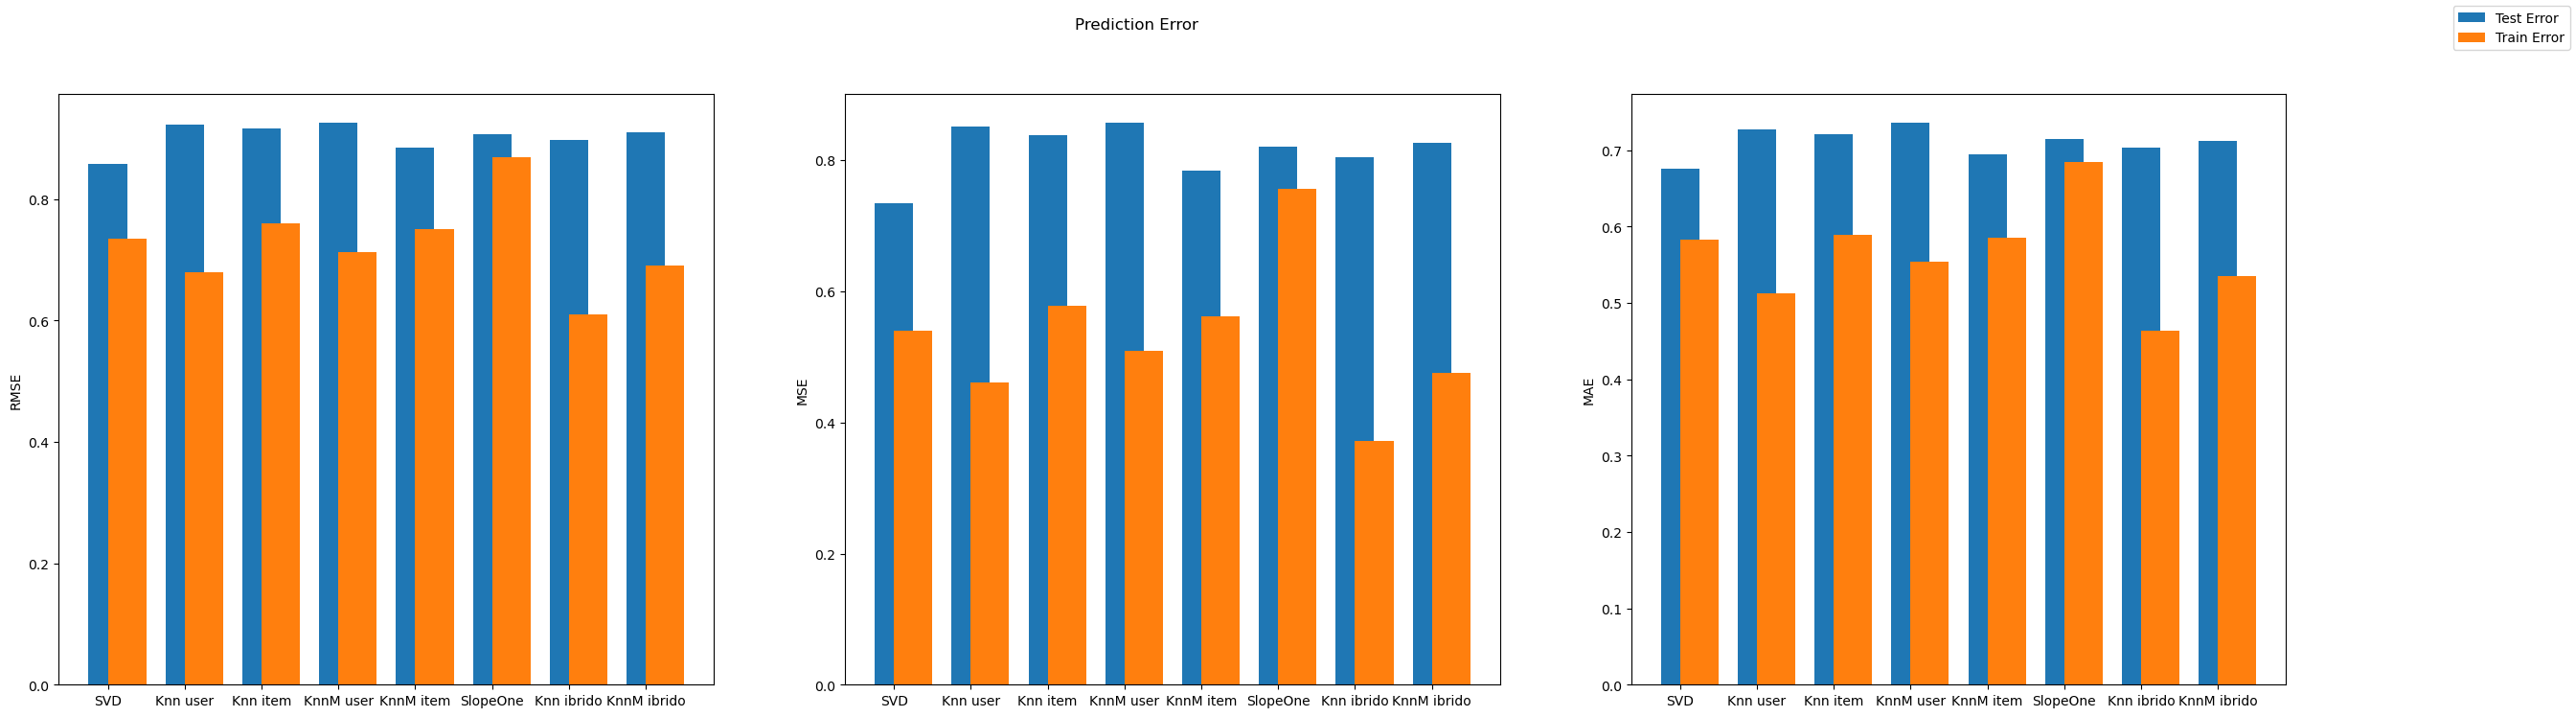

In [64]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(30,8))
fig.suptitle('Prediction Error')
ax1.bar(df["algo"],df["test_error_RMSE"],width=0.5, label="Test Error")
ax1.bar(df["algo"],df["train_error_RMSE"], width=0.5 ,align="edge", label="Train Error")
ax1.set(ylabel='RMSE')

ax2.bar(df["algo"],df["test_error_MSE"],width=0.5)
ax2.bar(df["algo"],df["train_error_MSE"],width=0.5,align="edge")
ax2.set(ylabel='MSE')

ax3.bar(df["algo"],df["test_error_MAE"],width=0.5)
ax3.bar(df["algo"],df["train_error_MAE"],width=0.5,align="edge")
ax3.set(ylabel='MAE')


fig.legend()
fig.show()
fig.savefig('img\Risultati_train_test_Error.jpg')

C:\Users\Elia\AppData\Local\Temp\ipykernel_20980\4093073322.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


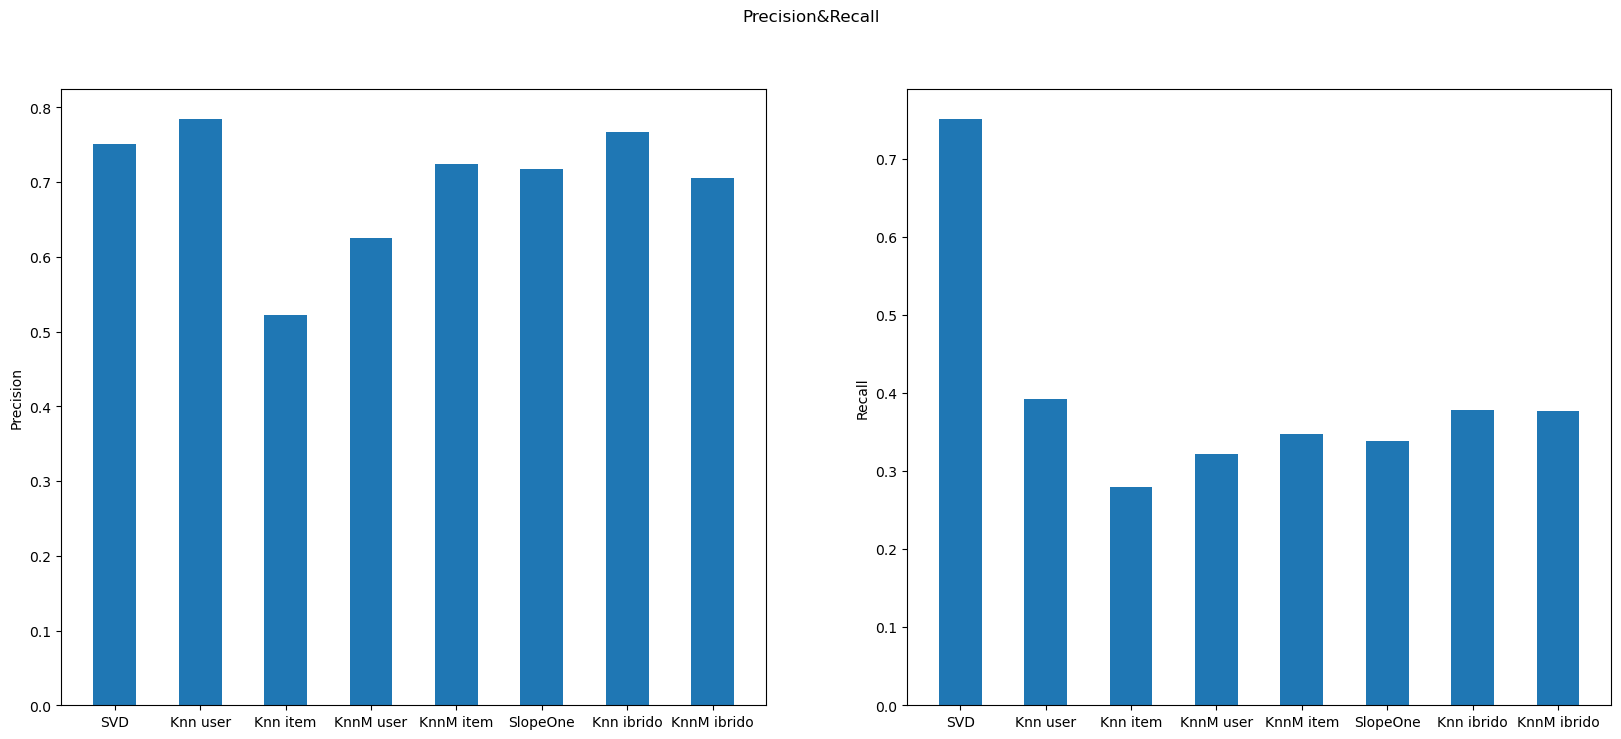

In [65]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
fig.suptitle('Precision&Recall')
ax1.bar(df["algo"],df["precision"],width=0.5)
ax1.set(ylabel='Precision')

ax2.bar(df["algo"],df["recall"],width=0.5)
ax2.set(ylabel='Recall')

fig.show()
fig.savefig('img\Risultati_Precision_recall.jpg')

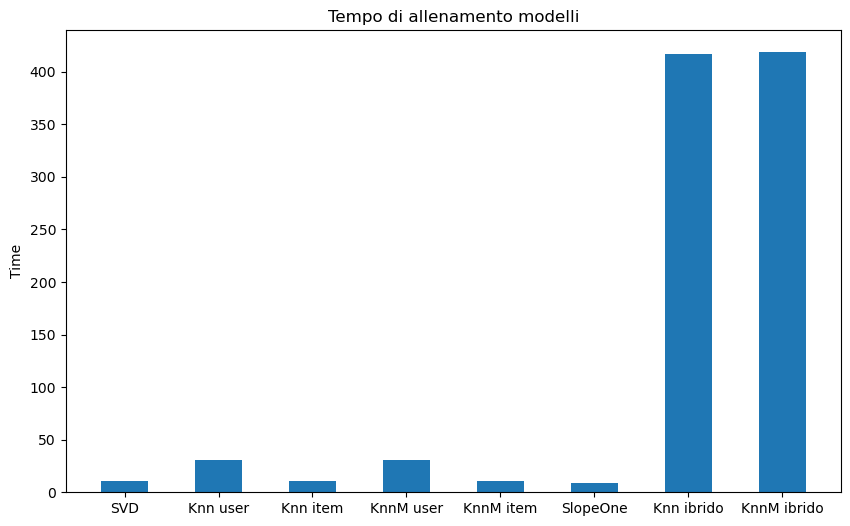

In [66]:
plt.figure(figsize=(10,6))
plt.title('Tempo di allenamento modelli')
plt.bar(df["algo"],df["train_time"],width=0.5)
plt.ylabel('Time')
plt.savefig('img\Risultati_train_time.jpg')